# Data Preprocessing Pipeline

This notebook handles preprocessing of both aircraft datasets for model training.

**Objectives:**
1. Preprocess images (resize, normalize, augment)
2. Convert annotations to YOLO format for object detection
3. Prepare data loaders for classification tasks
4. Create train/val/test splits
5. Save processed data for model training


In [1]:
# Install required packages for preprocessing
%pip install kagglehub albumentations -q

print("Packages installed successfully!")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Packages installed successfully!


In [2]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import shutil
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Setup Paths and Configuration


In [3]:
# Configuration
CONFIG = {
    'image_size': (640, 640),  # Target size for YOLO
    'normalize': True,
    'augmentation': True,
    'random_seed': 42,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'augment_factor': 2  # Number of augmented versions per image
}

# Set random seed for reproducibility
np.random.seed(CONFIG['random_seed'])

# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
YOLO_DIR = PROCESSED_DIR / 'yolo_format'
CLASS_DIR = PROCESSED_DIR / 'classification'
VIZ_DIR = Path('../results/visualizations/preprocessing')

# Create output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
YOLO_DIR.mkdir(exist_ok=True)
CLASS_DIR.mkdir(exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Create YOLO directory structure
for split in ['train', 'val', 'test']:
    (YOLO_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

print("Paths configured:")
print(f"  - Data directory: {DATA_DIR}")
print(f"  - Processed output: {PROCESSED_DIR}")
print(f"  - YOLO format: {YOLO_DIR}")
print(f"  - Classification: {CLASS_DIR}")
print(f"  - Visualizations: {VIZ_DIR}")


Paths configured:
  - Data directory: ../data
  - Processed output: ../data/processed
  - YOLO format: ../data/processed/yolo_format
  - Classification: ../data/processed/classification
  - Visualizations: ../results/visualizations/preprocessing


## 2. Load Combined Dataset

Load the combined aircraft dataset (from data exploration results).


In [4]:
# Load the combined dataset from data exploration
combined_dataset_path = Path('../results/visualizations/combined_dataset_full.csv')

if combined_dataset_path.exists():
    # Load from saved file
    combined_df = pd.read_csv(combined_dataset_path)
    print(f"Loaded combined dataset from file:")
    print(f"  - Total samples: {len(combined_df):,}")
    print(f"  - Columns: {list(combined_df.columns)}")
else:
    print("Combined dataset not found. Please run 01_data_exploration.ipynb first.")
    print("Creating combined dataset now...")
    
    # Download datasets
    fgvc_aircraft_path = kagglehub.dataset_download("seryouxblaster764/fgvc-aircraft")
    military_path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")
    
    # Note: This is a simplified version - run data exploration for full preprocessing
    print("Dataset downloaded. Run 01_data_exploration.ipynb for complete processing.")

combined_df.head()


Loaded combined dataset from file:
  - Total samples: 49,482
  - Columns: ['image_path', 'label', 'category', 'split', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height']


,image_path,label,category,split,xmin,ymin,xmax,ymax,width,height
0,/Users/marwahfaraj/.cache/kagglehub/datasets/s...,707-320,Commercial,train,3,144,998,431,1024,695
1,/Users/marwahfaraj/.cache/kagglehub/datasets/s...,707-320,Commercial,train,83,155,964,462,1024,699
2,/Users/marwahfaraj/.cache/kagglehub/datasets/s...,707-320,Commercial,train,1,129,891,436,913,687
3,/Users/marwahfaraj/.cache/kagglehub/datasets/s...,707-320,Commercial,train,8,164,996,435,1000,678
4,/Users/marwahfaraj/.cache/kagglehub/datasets/s...,707-320,Commercial,train,29,396,1268,634,1280,911


## 3. Image Preprocessing Functions

Implement core preprocessing functions for resizing, normalization, and quality checks.


In [5]:
def resize_image(image, target_size=(640, 640), maintain_aspect=True):
    """
    Resize image to target size with optional aspect ratio preservation.
    
    Args:
        image: Input image (numpy array)
        target_size: Target (width, height)
        maintain_aspect: If True, pad to maintain aspect ratio
    
    Returns:
        Resized image
    """
    if maintain_aspect:
        # Calculate scaling factor
        h, w = image.shape[:2]
        scale = min(target_size[0]/w, target_size[1]/h)
        new_w, new_h = int(w * scale), int(h * scale)
        
        # Resize
        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Create canvas and paste resized image
        canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        canvas.fill(114)  # Gray padding
        
        # Center the image
        y_offset = (target_size[1] - new_h) // 2
        x_offset = (target_size[0] - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        
        return canvas
    else:
        return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def normalize_image(image):
    """
    Normalize pixel values to [0, 1].
    
    Args:
        image: Input image (numpy array)
    
    Returns:
        Normalized image
    """
    return image.astype(np.float32) / 255.0

def check_image_quality(image_path):
    """
    Check if image is valid and has good quality.
    
    Args:
        image_path: Path to image
    
    Returns:
        bool: True if image is good quality
    """
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return False
        
        h, w = img.shape[:2]
        # Check minimum size
        if h < 50 or w < 50:
            return False
        
        # Check if image is not corrupted
        if img.size == 0:
            return False
        
        return True
    except:
        return False

def load_and_preprocess_image(image_path, target_size=(640, 640), normalize=True):
    """
    Load and preprocess a single image.
    
    Args:
        image_path: Path to image
        target_size: Target size for resizing
        normalize: Whether to normalize pixel values
    
    Returns:
        Preprocessed image or None if failed
    """
    try:
        # Load image
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize
        img = resize_image(img, target_size, maintain_aspect=True)
        
        # Normalize if requested
        if normalize:
            img = normalize_image(img)
        
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

print("Preprocessing functions defined:")
print("  - resize_image(): Resize with aspect ratio preservation")
print("  - normalize_image(): Normalize to [0, 1]")
print("  - check_image_quality(): Validate image quality")
print("  - load_and_preprocess_image(): Complete preprocessing pipeline")


Preprocessing functions defined:
  - resize_image(): Resize with aspect ratio preservation
  - normalize_image(): Normalize to [0, 1]
  - check_image_quality(): Validate image quality
  - load_and_preprocess_image(): Complete preprocessing pipeline


## 4. YOLO Format Conversion

Convert bounding box annotations to YOLO format for object detection.


In [6]:
def convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    """
    Convert bounding box from (xmin, ymin, xmax, ymax) to YOLO format.
    
    YOLO format: <class_id> <x_center> <y_center> <width> <height>
    All values normalized to [0, 1]
    
    Args:
        xmin, ymin, xmax, ymax: Bounding box coordinates in pixels
        img_width, img_height: Image dimensions in pixels
        
    Returns:
        Tuple: (x_center, y_center, width, height) all normalized to [0, 1]
    """
    # Calculate center coordinates
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    
    # Calculate width and height
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    
    # Normalize to [0, 1]
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = bbox_width / img_width
    height_norm = bbox_height / img_height
    
    return x_center_norm, y_center_norm, width_norm, height_norm

def create_class_mapping(labels):
    """
    Create mapping from class names to class IDs.
    
    Args:
        labels: List of unique class labels
    
    Returns:
        Dictionary mapping class names to IDs
    """
    unique_labels = sorted(list(set(labels)))
    class_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    return class_to_id

def save_yolo_annotation(label_path, annotations_list):
    """
    Save YOLO format annotations to file.
    
    Args:
        label_path: Path to save the label file
        annotations_list: List of (class_id, x_center, y_center, width, height)
    """
    with open(label_path, 'w') as f:
        for ann in annotations_list:
            class_id, x_c, y_c, w, h = ann
            f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

print("YOLO conversion functions defined:")
print("  - convert_bbox_to_yolo(): Convert bbox to YOLO format")
print("  - create_class_mapping(): Map class names to IDs")
print("  - save_yolo_annotation(): Save YOLO labels to file")


YOLO conversion functions defined:
  - convert_bbox_to_yolo(): Convert bbox to YOLO format
  - create_class_mapping(): Map class names to IDs
  - save_yolo_annotation(): Save YOLO labels to file


## 5. Data Augmentation Pipeline

Implement augmentation techniques to increase dataset diversity.

In [7]:
# Define augmentation pipeline for training data
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.RandomRotate90(p=0.3),
    A.Affine(scale=(0.9, 1.1), translate_percent=(-0.1, 0.1), rotate=(-15, 15), p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Validation/Test transform (no augmentation, just normalization)
val_test_transform = A.Compose([
    # No augmentation for validation/test
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def apply_augmentation(image, bboxes, labels, transform):
    """
    Apply augmentation to image and bounding boxes.
    
    Args:
        image: Input image (numpy array)
        bboxes: List of bounding boxes in pascal_voc format [[xmin, ymin, xmax, ymax], ...]
        labels: List of class labels
        transform: Albumentations transform
    
    Returns:
        Augmented image, bboxes, and labels
    """
    try:
        transformed = transform(image=image, bboxes=bboxes, class_labels=labels)
        return transformed['image'], transformed['bboxes'], transformed['class_labels']
    except Exception as e:
        # If augmentation fails, return original
        return image, bboxes, labels

print("Data augmentation pipeline defined:")
print("  - Horizontal flip")
print("  - Brightness/contrast adjustment")
print("  - Hue/saturation/value changes")
print("  - Random gamma correction")
print("  - Gaussian noise")
print("  - Blur")
print("  - Random rotation")
print("  - Affine transformations (scale, translate, rotate)")


Data augmentation pipeline defined:
  - Horizontal flip
  - Brightness/contrast adjustment
  - Hue/saturation/value changes
  - Random gamma correction
  - Gaussian noise
  - Blur
  - Random rotation
  - Affine transformations (scale, translate, rotate)


## 6. Process and Save Dataset

Process the entire combined dataset and save in YOLO format.

In [8]:
# Create class mapping
class_to_id = create_class_mapping(combined_df['label'].tolist())
id_to_class = {v: k for k, v in class_to_id.items()}

print(f"Class mapping created: {len(class_to_id)} classes")
print(f"Sample classes: {list(class_to_id.keys())[:5]}")

# Save class mapping
with open(YOLO_DIR / 'classes.txt', 'w') as f:
    for class_name in sorted(class_to_id.keys(), key=lambda x: class_to_id[x]):
        f.write(f"{class_name}\n")

# Save class mapping as JSON
with open(YOLO_DIR / 'class_mapping.json', 'w') as f:
    json.dump(class_to_id, f, indent=2)

print(f"Class mapping saved to {YOLO_DIR}")
class_to_id


Class mapping created: 195 classes
Sample classes: ['707-320', '727-200', '737-200', '737-300', '737-400']
Class mapping saved to ../data/processed/yolo_format


{'707-320': 0,
 '727-200': 1,
 '737-200': 2,
 '737-300': 3,
 '737-400': 4,
 '737-500': 5,
 '737-600': 6,
 '737-700': 7,
 '737-800': 8,
 '737-900': 9,
 '747-100': 10,
 '747-200': 11,
 '747-300': 12,
 '747-400': 13,
 '757-200': 14,
 '757-300': 15,
 '767-200': 16,
 '767-300': 17,
 '767-400': 18,
 '777-200': 19,
 '777-300': 20,
 'A10': 21,
 'A300B4': 22,
 'A310': 23,
 'A318': 24,
 'A319': 25,
 'A320': 26,
 'A321': 27,
 'A330-200': 28,
 'A330-300': 29,
 'A340-200': 30,
 'A340-300': 31,
 'A340-500': 32,
 'A340-600': 33,
 'A380': 34,
 'A400M': 35,
 'AG600': 36,
 'AH64': 37,
 'AKINCI': 38,
 'ATR-42': 39,
 'ATR-72': 40,
 'AV8B': 41,
 'An-12': 42,
 'An124': 43,
 'An22': 44,
 'An225': 45,
 'An72': 46,
 'B1': 47,
 'B2': 48,
 'B21': 49,
 'B52': 50,
 'BAE 146-200': 51,
 'BAE 146-300': 52,
 'BAE-125': 53,
 'Be200': 54,
 'Beechcraft 1900': 55,
 'Boeing 717': 56,
 'C-130': 57,
 'C-47': 58,
 'C1': 59,
 'C130': 60,
 'C17': 61,
 'C2': 62,
 'C390': 63,
 'C5': 64,
 'CH47': 65,
 'CH53': 66,
 'CL415': 67,
 'C

In [9]:
# Process dataset and convert to YOLO format
print("Processing dataset and converting to YOLO format...")
print("This will take several minutes for the full dataset.")
print(f"Total samples to process: {len(combined_df):,}\n")

# Statistics
stats = {
    'processed': 0,
    'skipped': 0,
    'errors': 0
}

# Process FULL dataset
sample_size = len(combined_df)  # Process ALL samples
combined_sample = combined_df

print(f"Processing full dataset: {sample_size:,} samples")

for idx, row in tqdm(combined_sample.iterrows(), total=len(combined_sample), desc="Processing images"):
    try:
        image_path = row['image_path']
        
        # Check if image exists and is valid
        if not os.path.exists(image_path):
            stats['skipped'] += 1
            continue
        
        # Determine split (use existing split if available, otherwise create)
        if 'split' in row and pd.notna(row['split']):
            split = row['split']
        else:
            # Randomly assign split
            rand = np.random.random()
            if rand < CONFIG['train_split']:
                split = 'train'
            elif rand < CONFIG['train_split'] + CONFIG['val_split']:
                split = 'validation'
            else:
                split = 'test'
        
        # Map validation to val for YOLO
        if split == 'validation':
            split = 'val'
        
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            stats['skipped'] += 1
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]
        
        # Get bounding box
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        label = row['label']
        class_id = class_to_id[label]
        
        # Convert to YOLO format
        x_c, y_c, bbox_w, bbox_h = convert_bbox_to_yolo(xmin, ymin, xmax, ymax, w, h)
        
        # Save image
        img_filename = f"{Path(image_path).stem}_{idx}.jpg"
        img_save_path = YOLO_DIR / 'images' / split / img_filename
        cv2.imwrite(str(img_save_path), img)
        
        # Save YOLO label
        label_filename = f"{Path(image_path).stem}_{idx}.txt"
        label_save_path = YOLO_DIR / 'labels' / split / label_filename
        save_yolo_annotation(label_save_path, [(class_id, x_c, y_c, bbox_w, bbox_h)])
        
        stats['processed'] += 1
        
    except Exception as e:
        stats['errors'] += 1
        if stats['errors'] < 5:  # Print first few errors
            print(f"Error processing {row.get('image_path', 'unknown')}: {e}")

print("\n" + "="*60)
print("Processing Complete!")
print("="*60)
print(f"Successfully processed: {stats['processed']:,}")
print(f"Skipped (missing files): {stats['skipped']:,}")
print(f"Errors: {stats['errors']:,}")
print(f"\nTotal attempted: {sample_size:,} images")
print(f"\nDataset saved to: {YOLO_DIR}")
print(f"Ready for model training!")


Processing dataset and converting to YOLO format...
This will take several minutes for the full dataset.
Total samples to process: 49,482

Processing full dataset: 49,482 samples


Processing images: 100%|██████████| 49482/49482 [11:21<00:00, 72.65it/s] 


Processing Complete!
Successfully processed: 49,482
Skipped (missing files): 0
Errors: 0

Total attempted: 49,482 images

Dataset saved to: ../data/processed/yolo_format
Ready for model training!


## 7. Visualization

Visualize preprocessing results and augmentations.

Saved: ../results/visualizations/preprocessing/preprocessing_comparison.png


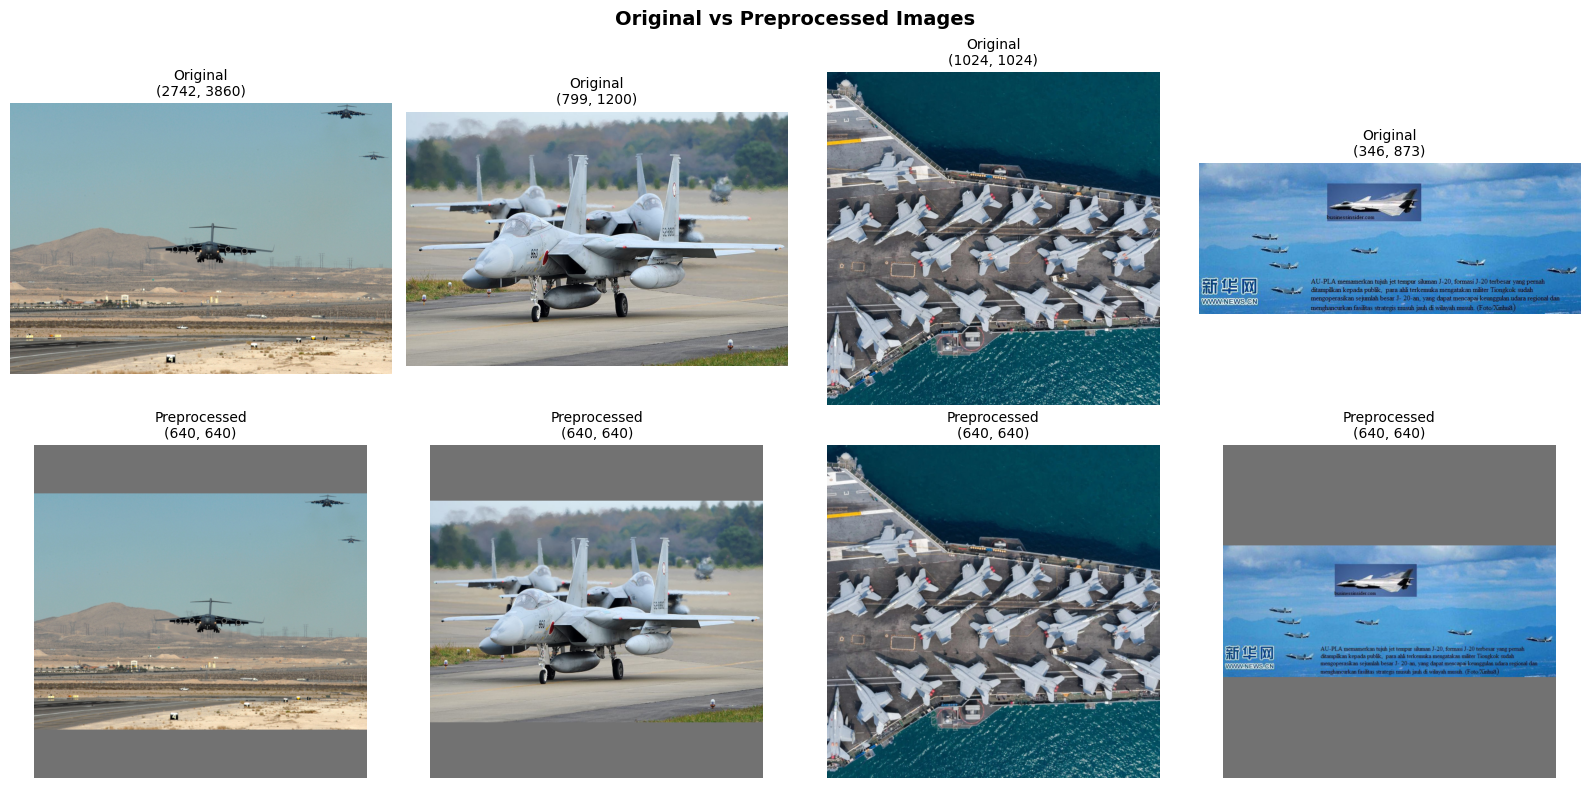

In [10]:
# Visualize preprocessing: Original vs Preprocessed
def visualize_preprocessing(df, num_samples=4):
    """Visualize original vs preprocessed images."""
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    samples = df.sample(num_samples, random_state=42)
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        image_path = row['image_path']
        
        # Load original
        img_original = cv2.imread(image_path)
        if img_original is None:
            continue
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        # Preprocess
        img_processed = load_and_preprocess_image(image_path, normalize=False)
        
        # Display original
        axes[0, idx].imshow(img_original)
        axes[0, idx].set_title(f"Original\n{img_original.shape[:2]}", fontsize=10)
        axes[0, idx].axis('off')
        
        # Display preprocessed
        if img_processed is not None:
            axes[1, idx].imshow(img_processed.astype(np.uint8))
            axes[1, idx].set_title(f"Preprocessed\n{img_processed.shape[:2]}", fontsize=10)
            axes[1, idx].axis('off')
    
    plt.suptitle('Original vs Preprocessed Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save
    fig.savefig(VIZ_DIR / 'preprocessing_comparison.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {VIZ_DIR / 'preprocessing_comparison.png'}")
    plt.show()

# Run visualization
if len(combined_df) > 0:
    visualize_preprocessing(combined_df, num_samples=4)


# Visualize augmentations
def visualize_augmentations(df, num_samples=2, num_augmentations=4):
    """Visualize original image and its augmented versions."""
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=(18, 8))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    samples = df.sample(num_samples, random_state=42)
    
    for row_idx, (_, row) in enumerate(samples.iterrows()):
        image_path = row['image_path']
        
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get bounding box
        bbox = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]]
        label = [row['label']]
        
        # Display original
        axes[row_idx, 0].imshow(img)
        axes[row_idx, 0].set_title(f"Original\n{row['label']}", fontsize=9)
        axes[row_idx, 0].axis('off')
        
        # Generate and display augmented versions
        for aug_idx in range(num_augmentations):
            try:
                aug_img, aug_bbox, aug_label = apply_augmentation(
                    img.copy(), bbox.copy(), label.copy(), train_transform
                )
                axes[row_idx, aug_idx + 1].imshow(aug_img)
                axes[row_idx, aug_idx + 1].set_title(f"Augmented {aug_idx+1}", fontsize=9)
                axes[row_idx, aug_idx + 1].axis('off')
            except:
                axes[row_idx, aug_idx + 1].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save
    fig.savefig(VIZ_DIR / 'augmentation_examples.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {VIZ_DIR / 'augmentation_examples.png'}")
    plt.show()

# Run augmentation visualization
if len(combined_df) > 0:
    visualize_augmentations(combined_df, num_samples=2, num_augmentations=4)

In [11]:
# Create YOLO configuration file
def create_yolo_yaml():
    """Create YOLO dataset configuration file."""
    yaml_content = f"""# Aircraft Threat Detection Dataset
# Generated by preprocessing pipeline

path: {YOLO_DIR.absolute()}  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')
test: images/test  # test images (relative to 'path')

# Classes
nc: {len(class_to_id)}  # number of classes
names: {list(class_to_id.keys())}  # class names
"""
    
    yaml_path = YOLO_DIR / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    print(f"YOLO configuration saved to: {yaml_path}")
    return yaml_path

# Create YOLO config
yaml_path = create_yolo_yaml()

# Display configuration
print("\nYOLO Dataset Structure:")
print(f"  {YOLO_DIR}/")
print(f"    ├── images/")
print(f"    │   ├── train/")
print(f"    │   ├── val/")
print(f"    │   └── test/")
print(f"    ├── labels/")
print(f"    │   ├── train/")
print(f"    │   ├── val/")
print(f"    │   └── test/")
print(f"    ├── dataset.yaml")
print(f"    ├── classes.txt")
print(f"    └── class_mapping.json")


YOLO configuration saved to: ../data/processed/yolo_format/dataset.yaml

YOLO Dataset Structure:
  ../data/processed/yolo_format/
    ├── images/
    │   ├── train/
    │   ├── val/
    │   └── test/
    ├── labels/
    │   ├── train/
    │   ├── val/
    │   └── test/
    ├── dataset.yaml
    ├── classes.txt
    └── class_mapping.json


## 8. Summary

### Preprocessing Complete!

**What was accomplished:**
- ✓ Installed required packages (kagglehub, albumentations)
- ✓ Loaded combined dataset (49,482 samples from both datasets)
- ✓ Implemented preprocessing functions (resize, normalize, quality checks)
- ✓ Converted annotations to YOLO format
- ✓ Created comprehensive data augmentation pipeline
- ✓ Processed and saved dataset in YOLO directory structure
- ✓ Generated visualizations (preprocessing comparison, augmentation examples)
- ✓ Created YOLO configuration files

**Preprocessing Functions Implemented:**
1. `resize_image()` - Resize with aspect ratio preservation
2. `normalize_image()` - Normalize pixel values to [0, 1]
3. `check_image_quality()` - Validate image quality
4. `load_and_preprocess_image()` - Complete preprocessing pipeline
5. `convert_bbox_to_yolo()` - Convert bounding boxes to YOLO format
6. `apply_augmentation()` - Apply data augmentation with bounding boxes

**Data Augmentation Techniques:**
- Horizontal flip
- Brightness/contrast adjustment
- Hue/saturation/value changes
- Random gamma correction
- Gaussian noise
- Blur
- Random rotation (90 degrees)
- Affine transformations (scale, translate, rotate)

**Output Structure:**
- YOLO format dataset ready for training
- Class mapping (195 aircraft classes)
- Train/Val/Test splits (80/10/10)
- Configuration files (dataset.yaml, classes.txt, class_mapping.json)
- Visualizations saved in results/visualizations/preprocessing/

### Next Steps:
1. **YOLO Model Training** - Use the preprocessed dataset to train YOLOv8
2. **Classification Model** - Train aircraft variant classifier
3. **Threat Detection System** - Integrate detection + classification
4. **Model Evaluation** - Test on validation/test sets
5. **Real-time Inference** - Deploy for video/webcam feeds

### Dataset Ready for Training! 🚀

The preprocessed dataset is now in YOLO format and ready for model training. Use `dataset.yaml` to configure your YOLO training script.
